In [12]:
import tensorflow as tf

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Check the shape of the data
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


This is a data driven study of grouping tasks


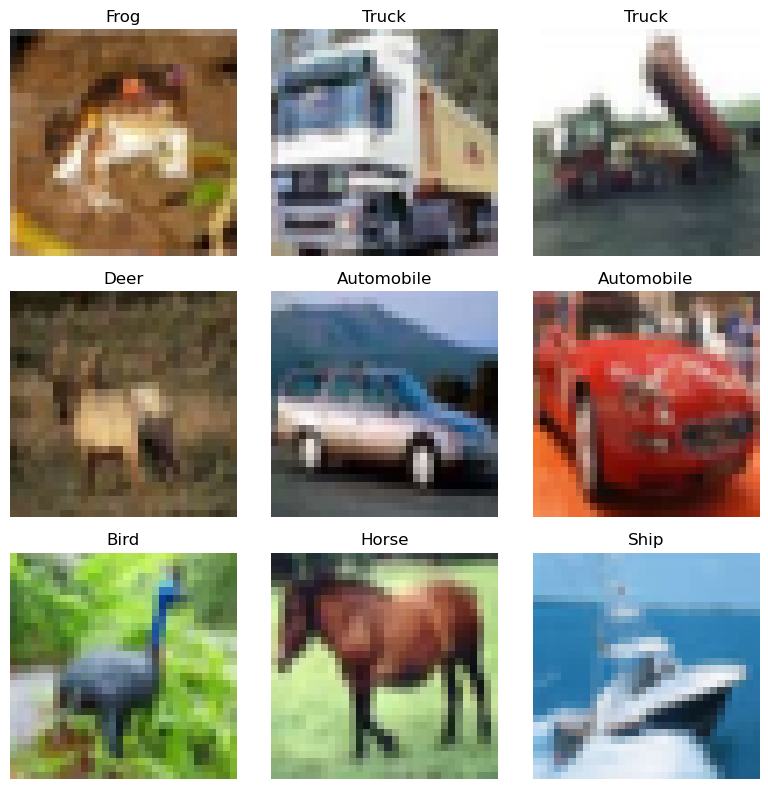

In [13]:
import matplotlib.pyplot as plt

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to plot images with labels
def plot_images(images, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(class_names[label[0]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few images to display
plot_images(x_train[:9], y_train[:9])


In [14]:
import numpy as np
unique_values = np.unique(y_train)

print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


In [15]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)

In [16]:
y_train_one_hot[:20]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [18]:
y_train_one_hot[y_train_one_hot == 0] = -1

We look at the correlation matrix of the tasks to see how good a predictore it is of the pairing discovered in \grouping2023

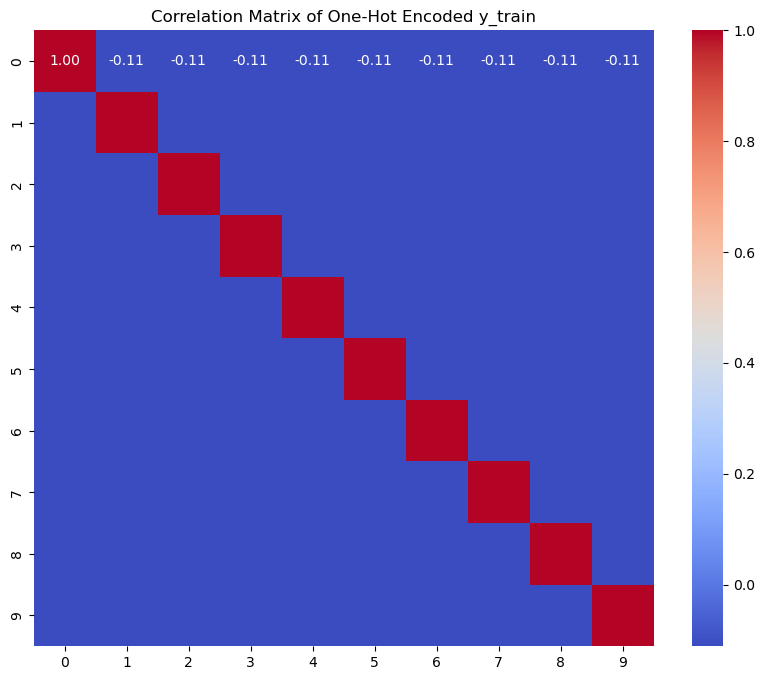

In [19]:

import seaborn as sns


# Calculate the correlation matrix
correlation_matrix = np.corrcoef(y_train_one_hot, rowvar=False)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of One-Hot Encoded y_train")
plt.show()


obviously the classes are mutually exclusive (and there is the same number of pictures in each class)

Next, we implement horizontal division (when the indices on which we define a topology are horizontal - ie we consider subsets of datapoints)

I. Inspired by the original example in sheaves for data,We pick a task of interest and 
A. Generate all the subsets build by all possible unions $U_i=\{j/y_{ji}=1$ with $j$ distinct of the task of interest.
B. For any such subset, we generate the $\Lambda_k$ filtration of $U$ which is a function that takes as input a boolean array of length 10 with 1s for the "j" included in $U=\bigcup_j U_j$ and returning a (10,?) array where $?$ is a function of $k$. For $k=1$, it is 9 unless $U$ was already a one class subset in which case the output should be None.
C. For some determined $V$ (coded as length 10 Boolean array), the function indices_V returns the array of indices for which $y_j=1$ for at least one of the $j$.t. V_j=1$ 
D. The function SigmaXy of the DataBase class takes an index array "index" indicating the subsets of rows that we want to consider and an integer $i$ indicating which is the task of interest, and returning $1/len(index)y_i^TX$
E. For an input $U$ and an integer $k$ indicating the degree of filtration to consider, the function Incon_k_U of the database class returns a list containing, for each column V in the k-filtration of $U$, a pair of a positive real $d=(SigmaXy(U),SigmaXy(V))$ of a 10-array indicating which $j$ have been removed of $U$ to produce $V$. It also returns a 10 array indicating for which removed $j´s$ the distance was maximum.
F. An helper function subsets that takes a 10 array representing $U$, and returns a list of arrays containing all possible arrays with 0 values in the same positions as the input.
G. The function Incon_k takes an integer $k$ and an integer $i$ indicating which is the task of interest. It then computes for each $V$ outputed by subsets(U) incon_k_U(k,V) and counts for each $j´s$ array how many times it was associated with the highest inconsistency.
A function Histo_k that takes as input the output of the last function and returns an histogram with a bar for each 'at most k combinations of targets' how many times each of them is causing the biggest shift in the correlation matrix for a given task of interest.

In [ ]:
class MyArrayClass:
    def __init__(self, array):
        # Check if the input is a 2D numpy array
        if isinstance(array, np.ndarray) and array.ndim == 2:
            self.array = array
        else:
            raise ValueError("Input must be a 2D numpy array")